## Imports and Setup

In [1]:
#@Imports
import sys
import os
path = os.path.abspath('../..')
if path not in sys.path:
  sys.path.insert(0, path)

%load_ext autoreload

import collections
import concurrent.futures
import datetime
import json
import termcolor
import re

import numpy as np

from IPython import display

from concordia.agents import basic_agent
from concordia.components import agent as components
from concordia import components as generic_components
from concordia.associative_memory import associative_memory
from concordia.associative_memory import blank_memories
from concordia.associative_memory import formative_memories
from concordia.associative_memory import importance_function
from concordia.clocks import game_clock
from concordia.components import game_master as gm_components
from concordia.environment import game_master
from concordia.metrics import goal_achievement
from concordia.metrics import common_sense_morality
from concordia.metrics import opinion_of_others
from concordia.typing import agent as simulacrum_agent
from concordia.utils import html as html_lib
from concordia.utils import measurements as measurements_lib
from concordia.utils import plotting

from examples.custom_components.setup import model_setup, measurement_setup

In [2]:
#@Model Setup
model, embedder = model_setup('llama3:70b', local_models=True)
measurements, clock = measurement_setup(
  SETUP_TIME=datetime.datetime(hour=21, year=2024, month=10, day=1), 
  time_step = datetime.timedelta(minutes=5))

#@title Importance models
importance_model = importance_function.ConstantImportanceModel()
importance_model_gm = importance_function.ConstantImportanceModel()

## Scenario Details

In [26]:
#@Shared Memories

# The generic context will be used for the NPC context. It reflects general
# knowledge and is possessed by all characters.
scenario_premise = [
  (
    'It is 9pm on a weeknight. ' +
    'Alice returns late from work and finds her friend Dorothy at her doorstep. '
  ),
]
shared_context = model.sample_text(
  'Summarize the following passage in a concise and insightful fashion:\n'
  + '\n'.join(scenario_premise)
  + '\n'
  + 'Summary:'
)

#@title Creating character backgrounds, goals and traits. Modify to explore how it influences the outcomes

player_configs = [
  
  # Dorothy
  formative_memories.AgentConfig(
    name='Dorothy',
    gender='female',
    goal=(
      'Dorothy has to move out of her house tonight and needs someone to help her move. ' +
      "Dorothy had planned on Bob helping her move, but Bob didn't show up. " 
    ),
    context=shared_context,
    traits='responsibility: medium; aggression: medium',
  ),

  # Alice
  formative_memories.AgentConfig(
    name='Alice',
    gender='female',
    goal='Alice is exhausted after work, and she needs to help her grandmother all day the next day.',
    context=shared_context,
    traits='responsibility: medium; aggression: medium',
  )
]

#@Memory factories
blank_memory_factory = blank_memories.MemoryFactory(
  model=model,
  embedder=embedder,
  importance=importance_model.importance,
  clock_now=clock.now,
)

formative_memory_factory = formative_memories.FormativeMemoryFactory(
  model=model,
  shared_memories=scenario_premise,
  blank_memory_factory_call=blank_memory_factory.make_blank_memory,
)

Alice comes home from work late one weekday evening to find an unexpected visitor, her friend Dorothy, waiting for her at the door.

## Agent Structure

In [6]:
#@Define agent structure
%autoreload 2
from examples.custom_components import tpb_llama3 as tpb

def build_agent(player_config) -> basic_agent.BasicAgent:

  mem = formative_memory_factory.make_memories(player_config)

  behav = tpb.Behaviour(
    "behaviour",
    model=model,
    memory=mem,
    player_config=player_config,
    num_behavs=5
  )

  attitude = tpb.Attitude(
    "attitude",
    model=model,
    memory=mem,
    player_config=player_config,
    components=[behav],
  )

  people = tpb.People(
    "people",
    model=model,
    memory=mem,
    player_config=player_config,
    components=[behav]
  )

  motiv = tpb.Motivation(
    "motivation",
    model=model,
    memory=mem,
    player_config=player_config,
    components=[people]
  )

  norm = tpb.SubjectiveNorm(
    "norm",
    model=model,
    memory=mem,
    player_config=player_config,
    components=[motiv]
  )

  full_model = tpb.TPB(
    "tpb",
    model=model,
    memory=mem,
    player_config=player_config,
    components=[attitude,norm]
  )

  persona = generic_components.sequential.Sequential(
    name='persona',
    components=[
      behav,
      attitude,
      people,
      motiv,
      norm,
      full_model
    ]
  )

  situation = components.situation_perception.SituationPerception(
    name='situation',
    model=model,
    memory=mem,
    agent_name = player_config.name,
    clock_now=clock.now
  )

  plan = components.plan.SimPlan(
    model=model,
    memory=mem,
    agent_name=player_config.name,
    clock_now=clock.now,
    components=[situation],
    goal=full_model,
    time_adverb='5-minute',
    timescale='the next hour'
  )

  full_plan = generic_components.sequential.Sequential(
    name='full_plan',
    components=[
      persona,
      plan
    ]
  )

  agent = basic_agent.BasicAgent(
    agent_name=player_config.name,
    model=model,
    memory=mem,
    clock=clock,
    components=[full_plan]
  )
  
  return agent

In [7]:
#@Build agents
NUM_PLAYERS = 2
agents = []
with concurrent.futures.ThreadPoolExecutor(max_workers=NUM_PLAYERS) as pool:
  for agent in pool.map(build_agent,
            player_configs[:NUM_PLAYERS]):
    agents.append(agent)

Alice grew up in a modest household where her parents instilled in her a strong sense of responsibility and independence. As a child, she was always eager to lend a helping hand, whether it was feeding the family pet or assisting with household chores. This trait followed her into adulthood, where she pursued a career as a social worker, dedicating herself to supporting vulnerable families and individuals. Her typical day was filled with meetings, home visits, and paperwork, but Alice found joy in knowing that her work made a tangible difference in people's lives.

As she navigated her 30s and 40s, Alice's sense of responsibility only intensified. She became a respected figure in her community, known for her compassion and fairness. Her friends and family admired her ability to balance empathy with firmness, a quality that served her well in both her personal and professional life. However, this same sense of duty sometimes led to feelings of burnout and exhaustion. Alice's greatest fe

Number of generated formative episodes (1) does not match number of formative ages (5).


Based on Alice's memories and traits, here are 5 potential behaviors she may exhibit in response to Dorothy's request for help:

1. **Offer immediate assistance**: Despite being exhausted, Alice may put aside her own needs and offer to help Dorothy move out of her house that night, drawing from her past experiences of providing support and shelter to those in need.

2. **Suggest alternative solutions**: Alice might propose alternative solutions, such as finding temporary accommodation for Dorothy or helping her find a moving service, rather than taking on the task herself, given her own exhaustion and prior commitment to help her grandmother the next day.

3. **Provide emotional support but not physical help**: Alice may offer words of comfort and reassurance to Dorothy, acknowledging her difficult situation, while politely declining to provide physical assistance due to her own exhaustion and prior commitments.

4. **Negotiate a compromise**: Alice could propose helping Dorothy in a l

## GM Structure

In [27]:
game_master_memory = associative_memory.AssociativeMemory(
   sentence_embedder=embedder,
   importance=importance_model_gm.importance,
   clock=clock.now)

agent_list = [agent.name for agent in agents]

scenario_knowledge = generic_components.constant.ConstantComponent(
    state=' '.join(shared_context),
    name='Background')

player_status = gm_components.player_status.PlayerStatus(
    clock_now=clock.now,
    model=model,
    memory=game_master_memory,
    player_names=agent_list)


convo_externality = gm_components.conversation.Conversation(
    players=agents,
    model=model,
    memory=game_master_memory,
    clock=clock,
    burner_memory_factory=blank_memory_factory,
    components=[player_status],
    cap_nonplayer_characters=3,
    shared_context=shared_context,
    verbose=False,
)

direct_effect_externality = gm_components.direct_effect.DirectEffect(
    players=agents,
    model=model,
    memory=game_master_memory,
    clock_now=clock.now,
    verbose=False,
    components=[player_status]
)

relevant_events = gm_components.relevant_events.RelevantEvents(
    clock.now, model, game_master_memory)
time_display = gm_components.time_display.TimeDisplay(clock)

In [28]:
# @title Create the game master object
env = game_master.GameMaster(
    model=model,
    memory=game_master_memory,
    clock=clock,
    players=agents,
    components=[
        scenario_knowledge,
        player_status,
        convo_externality,
        direct_effect_externality,
        relevant_events,
        time_display,
    ],
    randomise_initiative=False,
    player_observes_event=False,
    verbose=True,
)

In [ ]:
# @title Expect about 2-3 minutes per step.
episode_length = 4  # @param {type: 'integer'}
for _ in range(episode_length):
  call_to_action = (
    f"Call to action goes here..."
  )
  env.step(action_spec = simulacrum_agent.ActionSpec(call_to_action=call_to_action))

In [24]:
from scipy.stats import zscore
from scipy.special import softmax

for agent in agents:
  print(agent.name)
  behaviours = [re.search(r'(.*?)(?=:)', behaviour["behaviour"]).group(1).replace('*', '').strip() for behaviour in agent._components["full_plan"]._components[0]._components[4].json()]
  attitudes = zscore([behaviour["attitude"] for behaviour in agent._components["full_plan"]._components[0]._components[1].json()])
  norms = zscore([behaviour["norm"] for behaviour in agent._components["full_plan"]._components[0]._components[4].json()])
  # Weighting factor
  w = 0.5
  behavioural_intentions = (w * attitudes) + ((1 - w) * norms)
  for i in range(len(behaviours)):
    print(f"Behaviour: {behaviours[i]}")
    print(f"Attitude: {attitudes[i]}, Norm: {norms[i]}, Intention: {behavioural_intentions[i]}")
    print(f"Action probabilities: {softmax(behavioural_intentions)[i]}")

Dorothy
Behaviour: Ask Alice for help
Attitude: 1.8781024586512467, Norm: 0.3437383445733994, Intention: 1.110920401612323
Action probabilities: 0.456089064714836
Behaviour: Call other friends or acquaintances for assistance
Attitude: -0.1785632218751609, Norm: 0.8124724508098533, Intention: 0.3169546144673462
Action probabilities: 0.20617438105020552
Behaviour: Try to contact Bob again
Attitude: -0.8162890142864502, Norm: 0.565085005851725, Intention: -0.12560200421736256
Action probabilities: 0.13244476650744463
Behaviour: Look for last-minute professional movers
Attitude: -0.003188628962056661, Norm: 0.23957520985418757, Intention: 0.11819329044606545
Action probabilities: 0.16901052593680704
Behaviour: Postpone the move until tomorrow
Attitude: -0.880061593527579, Norm: -1.9608710110891658, Intention: -1.4204663023083723
Action probabilities: 0.03628126179070687


In [7]:
from scipy.stats import zscore
from scipy.special import softmax

for agent in agents:
  behaviours = [re.search(r'(.*?)(?=:)', behaviour["behaviour"]).group(1).replace('*', '').strip() for behaviour in agent._components["behaviour"].json()]
  attitudes = zscore([behaviour["attitude"] for behaviour in agent._components["attitude"].json()])
  norms = zscore([behaviour["norm"] for behaviour in agent._components["norm"].json()])
  # Weighting factor
  w = 0.5
  behavioural_intentions = (w * attitudes) + ((1 - w) * norms)
  for i in range(len(behaviours)):
    print(f"Behaviour: {behaviours[i]}")
    print(f"Attitude: {attitudes[i]}, Norm: {norms[i]}, Intention: {behavioural_intentions[i]}")

Behaviour: Agree to help Dorothy immediately
Attitude: -0.9510309278350516, Norm: 1.2858424253127294, Intention: 0.1674057487388389
Behaviour: Offer alternative solutions
Attitude: 0.5953608247422675, Norm: -0.5893444449350015, Intention: 0.003008189903632996
Behaviour: Ask for clarification on the urgency
Attitude: 0.15721649484536063, Norm: -1.5939088397105714, Intention: -0.7183461724326053
Behaviour: Explain her own commitments and limitations
Attitude: 1.458762886597938, Norm: 0.6161328287956828, Intention: 1.0374478576968105
Behaviour: Negotiate a compromise
Attitude: -1.2603092783505156, Norm: 0.28127803053715894, Intention: -0.48951562390667835


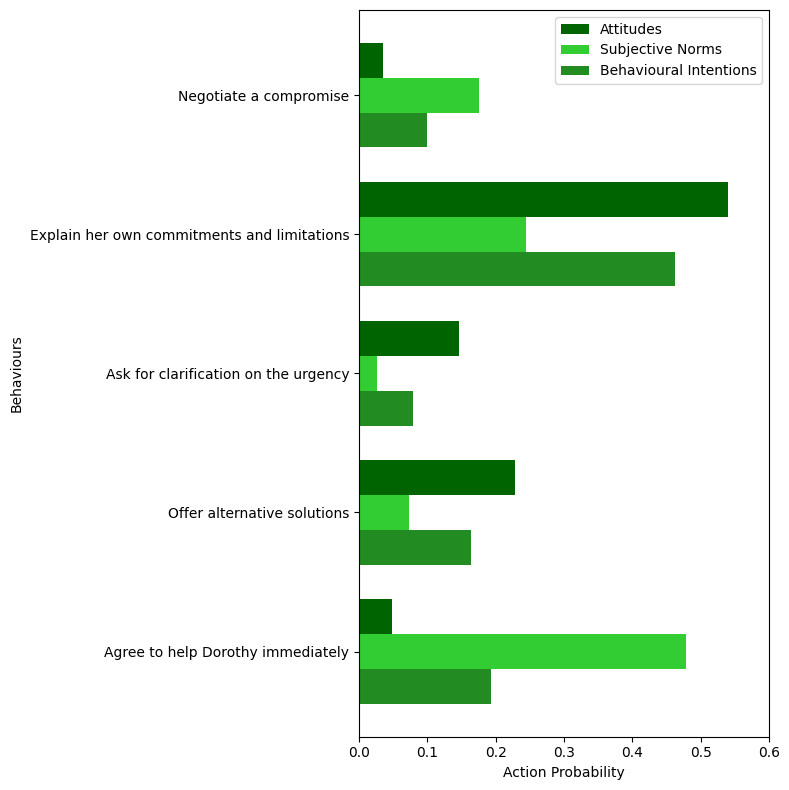

In [15]:
import matplotlib.pyplot as plt

bw = 0.25

b1 = np.arange(len(attitudes))
b2 = [x + bw for x in b1]
b3 = [x + bw for x in b2]

plt.figure(figsize=(8,8))

plt.barh(b3, softmax(attitudes), height = bw, color = 'darkgreen', label = 'Attitudes')
plt.barh(b2, softmax(norms), height = bw, color = 'limegreen', label = 'Subjective Norms')
plt.barh(b1, softmax(behavioural_intentions), height = bw, color = 'forestgreen', label = 'Behavioural Intentions')

plt.ylabel('Behaviours')
plt.xlabel('Action Probability')
plt.yticks([x + bw for x in b1], behaviours)
plt.xlim((0, 0.6))
# plt.yticks(rotation=90)
# plt.subplots_adjust(bottom=0.50)
plt.tight_layout()
plt.legend(loc="upper right")
plt.savefig('test.png', dpi = 150)

# plt.show()

### Things to add

- Summarize deliberation on the potential actions, including thoughts on the possible positive and negative consequences (counterfactuals should remain throughout the whole)
- 